In [2]:
from pandas import read_excel 
df = read_excel('Email Response Types.xlsx')
print(df.head())

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


                                            Response Type of Response
0  \nFrom: Dick, Andrew <adick@letica.com> \nSent...              Hot
1  From: David.Joyce@pinkerton.com <David.Joyce@p...              Hot
2  From: Derrick Brown <derrick.brown@csdental.co...              Hot
3  From: Christopher Antao <cantao@kdc.org> \nSen...              Hot
4  From: Connor, Jennifer <Jennifer.Connor@lanthe...              Hot


In [3]:
df['Type of Response'].replace(['Hot', 'hot', 'Warm', 'warm', 'Cold', 'cold', 'Negative', 'negative'], [2,2,1,1,-1,-1,-2,-2], inplace  = True)


In [4]:
df.head()

,Response,Type of Response
0,"\nFrom: Dick, Andrew <adick@letica.com> \nSent...",2
1,From: David.Joyce@pinkerton.com <David.Joyce@p...,2
2,From: Derrick Brown <derrick.brown@csdental.co...,2
3,From: Christopher Antao <cantao@kdc.org> \nSen...,2
4,"From: Connor, Jennifer <Jennifer.Connor@lanthe...",2


In [5]:
df.tail()

,Response,Type of Response
82,From: Donna Wright <DWright@CCCINC.net> \nSent...,-2
83,From: Leslie Barrios <leslie.barrios@bluebonne...,-2
84,From: Roy Jones <roy.jones@georgetownmtg.com> ...,-2
85,From: Jeff Holder <JHolder@astech.com> \nSent:...,-2
86,From: Pat Cowles @PD <PCowles@pape-dawson.com>...,-2


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 87 entries, 0 to 86
Data columns (total 2 columns):
Response            87 non-null object
Type of Response    87 non-null int64
dtypes: int64(1), object(1)
memory usage: 1.4+ KB


In [7]:
from email.parser import Parser

In [8]:
import pandas as pd
import re
email_body= []
for R in df['Response']:
    email = re.sub(r'(to\:[^\n]+\n|from\:[^\n]+\n|subject\:[^\n]+\n|sent\:[^\n]+\n|cc\:[^\n]+\n)', '', R.lower(), re.U)
    email_body.append(email)

In [9]:
EmailBody = pd.Series(email_body)
EmailBody.head()

0    \n\nhello kevin,\ni have time later next week....
1    \nright now that time looks ok.\n\ndavid joyce...
2    \nmark, \n\ni am available in the afternoon fr...
3    \nit is year end.  please reach out after july...
4    \nhi kevin,\n\nthanks for reaching out.  we'd ...
dtype: object

In [10]:
df['Response']=EmailBody

In [11]:
df.head()

,Response,Type of Response
0,"\n\nhello kevin,\ni have time later next week....",2
1,\nright now that time looks ok.\n\ndavid joyce...,2
2,"\nmark, \n\ni am available in the afternoon fr...",2
3,\nit is year end. please reach out after july...,2
4,"\nhi kevin,\n\nthanks for reaching out. we'd ...",2


In [12]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [13]:
texts= email_body
labels= df['Type of Response']
maxlen = 15  # We will cut the string after 15 words
max_words = 500  # We will only consider the top 500 words in the dataset

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

data = pad_sequences(sequences, maxlen=maxlen)

labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

# Split the data into a training set and a validation set
# But first, shuffle the data, since we started from data
# where samples are ordered (almost).
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]


Found 996 unique tokens.
Shape of data tensor: (87, 15)
Shape of label tensor: (87,)


In [35]:
x_train = data
y_train = labels

In [36]:
from keras.utils import to_categorical
y_train = to_categorical(y_train)


print(x_train.shape, y_train.shape)

(87, 15) (87, 3)


In [16]:
import os
embeddings_index = {}
f = open('glove.6B.100d.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


Found 400000 word vectors.


In [40]:
embedding_dim = 100

embedding_matrix = np.zeros((max_words, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < max_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [41]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Dropout
from keras import regularizers

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32,kernel_regularizer=regularizers.l2(0.001), activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 15, 100)           50000     
_________________________________________________________________
flatten_2 (Flatten)          (None, 1500)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 32)                48032     
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 99        
Total params: 98,131
Trainable params: 98,131
Non-trainable params: 0
_________________________________________________________________


In [42]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [43]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=32,
                    validation_split=0.2)
model.save_weights('pre_trained_glove_model.h5')

Train on 69 samples, validate on 18 samples
Epoch 1/10
69/69 [==============================] - 1s 20ms/step - loss: 0.9937 - acc: 0.4783 - val_loss: 0.8630 - val_acc: 0.4444
Epoch 2/10
69/69 [==============================] - 0s 232us/step - loss: 0.8554 - acc: 0.6087 - val_loss: 0.9813 - val_acc: 0.4444
Epoch 3/10
69/69 [==============================] - 0s 270us/step - loss: 0.7132 - acc: 0.6812 - val_loss: 0.7458 - val_acc: 0.5000
Epoch 4/10
69/69 [==============================] - 0s 386us/step - loss: 0.5679 - acc: 0.7681 - val_loss: 0.6691 - val_acc: 0.7222
Epoch 5/10
69/69 [==============================] - 0s 254us/step - loss: 0.4305 - acc: 0.8696 - val_loss: 0.7829 - val_acc: 0.5000
Epoch 6/10
69/69 [==============================] - 0s 294us/step - loss: 0.4314 - acc: 0.8406 - val_loss: 0.8532 - val_acc: 0.5000
Epoch 7/10
69/69 [==============================] - 0s 288us/step - loss: 0.3961 - acc: 0.8551 - val_loss: 0.6946 - val_acc: 0.5556
Epoch 8/10
69/69 [===============

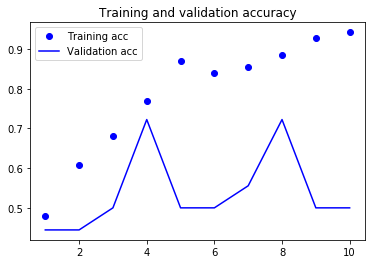

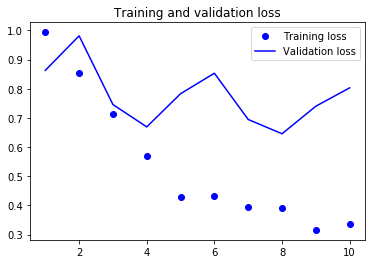

In [44]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [23]:
x_train = data
y_train = labels
y_train = to_categorical(y_train)

In [24]:
from keras.layers import Embedding, SimpleRNN

max_features = 500  # number of words to consider as features
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(SimpleRNN(32))
model.add(Dense(3, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Train on 69 samples, validate on 18 samples
Epoch 1/10
69/69 [==============================] - 1s 9ms/step - loss: 1.1103 - acc: 0.4348 - val_loss: 0.8906 - val_acc: 0.5556
Epoch 2/10
69/69 [==============================] - 0s 264us/step - loss: 0.9136 - acc: 0.5362 - val_loss: 0.8340 - val_acc: 0.6111
Epoch 3/10
69/69 [==============================] - 0s 264us/step - loss: 0.8159 - acc: 0.5507 - val_loss: 0.8078 - val_acc: 0.5556
Epoch 4/10
69/69 [==============================] - 0s 266us/step - loss: 0.7497 - acc: 0.6232 - val_loss: 0.7879 - val_acc: 0.6111
Epoch 5/10
69/69 [==============================] - 0s 263us/step - loss: 0.6992 - acc: 0.6812 - val_loss: 0.7746 - val_acc: 0.6111
Epoch 6/10
69/69 [==============================] - 0s 269us/step - loss: 0.6579 - acc: 0.6957 - val_loss: 0.7648 - val_acc: 0.6111
Epoch 7/10
69/69 [==============================] - 0s 267us/step - loss: 0.6226 - acc: 0.7101 - val_loss: 0.7570 - val_acc: 0.6667
Epoch 8/10
69/69 [================

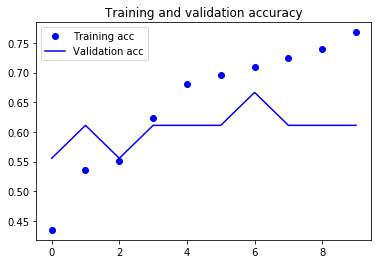

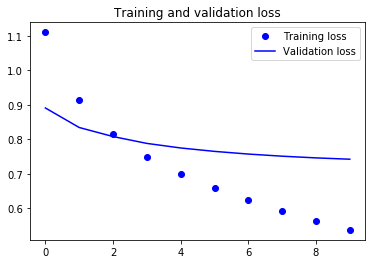

In [25]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [26]:
from keras.layers import LSTM

model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(LSTM(32))
model.add(Dense(3, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['acc'])
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)


Train on 69 samples, validate on 18 samples
Epoch 1/10
69/69 [==============================] - 2s 23ms/step - loss: 1.1121 - acc: 0.3913 - val_loss: 0.8927 - val_acc: 0.6667
Epoch 2/10
69/69 [==============================] - 0s 520us/step - loss: 0.9615 - acc: 0.5652 - val_loss: 0.8412 - val_acc: 0.7222
Epoch 3/10
69/69 [==============================] - 0s 559us/step - loss: 0.8878 - acc: 0.6377 - val_loss: 0.8039 - val_acc: 0.7778
Epoch 4/10
69/69 [==============================] - 0s 478us/step - loss: 0.8339 - acc: 0.6957 - val_loss: 0.7767 - val_acc: 0.7778
Epoch 5/10
69/69 [==============================] - 0s 601us/step - loss: 0.7911 - acc: 0.6957 - val_loss: 0.7552 - val_acc: 0.7222
Epoch 6/10
69/69 [==============================] - 0s 698us/step - loss: 0.7552 - acc: 0.7391 - val_loss: 0.7376 - val_acc: 0.6667
Epoch 7/10
69/69 [==============================] - 0s 616us/step - loss: 0.7246 - acc: 0.7826 - val_loss: 0.7229 - val_acc: 0.7222
Epoch 8/10
69/69 [===============

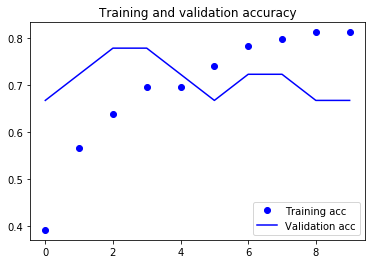

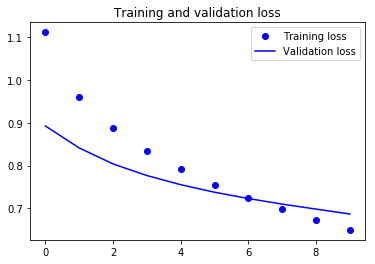

In [27]:


acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()



In [28]:
from keras import layers
model = Sequential()
model.add(layers.Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(layers.Bidirectional(layers.LSTM(32)))
model.add(layers.Dense(3, activation='softmax'))
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

In [29]:
model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=64,
validation_split=0.2)

Train on 69 samples, validate on 18 samples
Epoch 1/10
69/69 [==============================] - 3s 49ms/step - loss: 0.6727 - acc: 0.6667 - val_loss: 0.5893 - val_acc: 0.7222
Epoch 2/10
69/69 [==============================] - 0s 1ms/step - loss: 0.5371 - acc: 0.7536 - val_loss: 0.5359 - val_acc: 0.7407
Epoch 3/10
69/69 [==============================] - 0s 1ms/step - loss: 0.4961 - acc: 0.7633 - val_loss: 0.5371 - val_acc: 0.7037
Epoch 4/10
69/69 [==============================] - 0s 1ms/step - loss: 0.4774 - acc: 0.7585 - val_loss: 0.5623 - val_acc: 0.6296
Epoch 5/10
69/69 [==============================] - 0s 1ms/step - loss: 0.4753 - acc: 0.7585 - val_loss: 0.5060 - val_acc: 0.7037
Epoch 6/10
69/69 [==============================] - 0s 1ms/step - loss: 0.4351 - acc: 0.7826 - val_loss: 0.5113 - val_acc: 0.6296
Epoch 7/10
69/69 [==============================] - 0s 1ms/step - loss: 0.4247 - acc: 0.7778 - val_loss: 0.4845 - val_acc: 0.7593
Epoch 8/10
69/69 [===========================

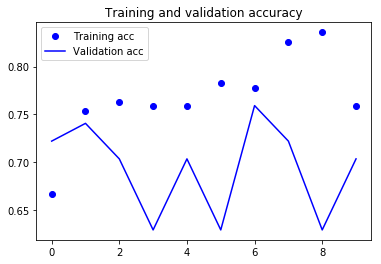

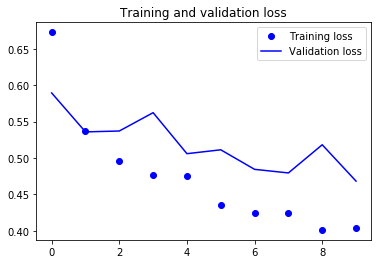

In [30]:

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [31]:
print('Pad sequences (samples x time)')
x_train = pad_sequences(sequences, maxlen=maxlen)

print('x_train shape:', x_train.shape)


Pad sequences (samples x time)
x_train shape: (87, 15)


In [50]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.Embedding(max_features, 100, input_length=maxlen))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 3, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(3))
model.summary()
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 15, 100)           50000     
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 13, 32)            9632      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 4, 32)             0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 2, 32)             3104      
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 3)                 99        
Total params: 62,835
Trainable params: 62,835
Non-trainable params: 0
_________________________________________________________________


In [51]:
model.compile(optimizer=RMSprop(lr=1e-4),
loss='binary_crossentropy',
metrics=['acc'])
history = model.fit(x_train, y_train,
epochs=10,
batch_size=128,
validation_split=0.2)

Train on 69 samples, validate on 18 samples
Epoch 1/10
69/69 [==============================] - 1s 22ms/step - loss: 3.5411 - acc: 0.4976 - val_loss: 3.0468 - val_acc: 0.5000
Epoch 2/10
69/69 [==============================] - 0s 149us/step - loss: 2.9560 - acc: 0.4686 - val_loss: 2.3286 - val_acc: 0.4815
Epoch 3/10
69/69 [==============================] - 0s 200us/step - loss: 2.7394 - acc: 0.4493 - val_loss: 2.2518 - val_acc: 0.4630
Epoch 4/10
69/69 [==============================] - 0s 202us/step - loss: 2.4142 - acc: 0.4493 - val_loss: 1.9780 - val_acc: 0.4815
Epoch 5/10
69/69 [==============================] - 0s 208us/step - loss: 1.9455 - acc: 0.4541 - val_loss: 1.5707 - val_acc: 0.5000
Epoch 6/10
69/69 [==============================] - 0s 178us/step - loss: 1.6290 - acc: 0.4444 - val_loss: 0.7767 - val_acc: 0.4630
Epoch 7/10
69/69 [==============================] - 0s 230us/step - loss: 1.4798 - acc: 0.4541 - val_loss: 0.6744 - val_acc: 0.4630
Epoch 8/10
69/69 [===============

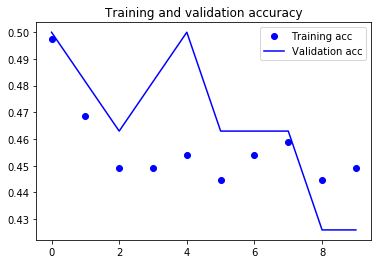

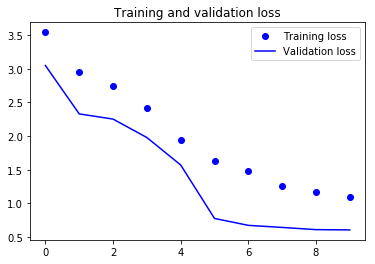

In [52]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()